# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [3]:
emal_nulls = df['email'].isnull().sum()
print(f"Number of Null email values is: {emal_nulls} ")

Number of Null email values is: 17 


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?

user_article = df.groupby('email')['article_id'].count()
user_article.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

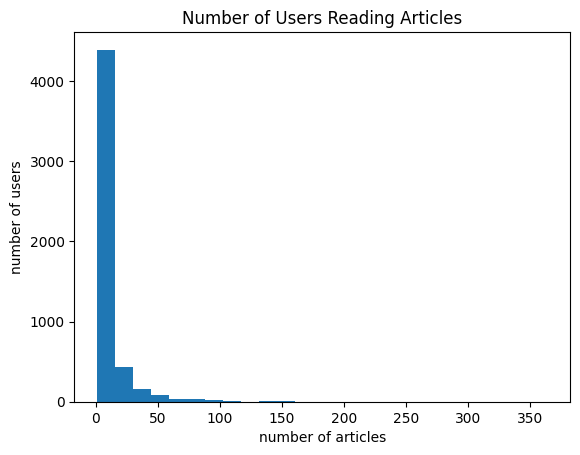

In [9]:
# Create a plot of the number of articles read by each user
plt.hist(user_article, bins=25)
plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

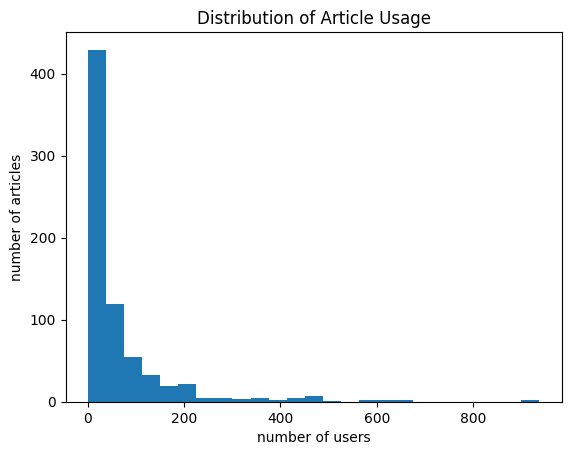

In [10]:
# Create a plot of the number of times each article was read
plt.hist(df.groupby('article_id')['email'].count(), bins=25)
plt.xlabel('number of users')
plt.ylabel('number of articles')
plt.title('Distribution of Article Usage')
plt.show()

In [13]:
# Fill in the median and maximum number of user_article interactions below

median_val = user_article.median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_article.max() # The maximum number of user-article interactions by any 1 user is ______.

# print the results
print(f"50% of individuals interact with {median_val} number of articles or fewer.")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}.")

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
unique_articles = df['article_id'].nunique()  # The number of unique articles that have at least one interaction
total_articles = df['article_id'].nunique()  # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = df.shape[0]  # The number of user-article interactions

# print the results
print(f"Number of unique articles that have at least one interaction: {unique_articles}")
print(f"Number of unique articles on the IBM platform: {total_articles}")
print(f"Number of unique users: {unique_users}")
print(f"Number of user-article interactions: {user_article_interactions}")

Number of unique articles that have at least one interaction: 714
Number of unique articles on the IBM platform: 714
Number of unique users: 5149
Number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
# verify the number of null values
df.isnull().sum()

Unnamed: 0    0
article_id    0
title         0
email         0
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45993 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [18]:
most_viewed_article_id = df['article_id'].value_counts().idxmax()  # The most viewed article in the dataset as a string with one value following the decimal
max_views = df['article_id'].value_counts().max()  # The most viewed article in the dataset was viewed how many times?

# print the results
print(f"The most viewed article in the dataset is {most_viewed_article_id} and it was viewed {max_views} times.")


The most viewed article in the dataset is 1429 and it was viewed 937 times.


In [19]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [20]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [21]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles = df.groupby('article_id')['user_id'].count().reset_index()
    top_articles = top_articles.sort_values('user_id', ascending=False)
    top_articles = top_articles['article_id'].iloc[0:n]
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    top_articles_ids = df.groupby('article_id')['user_id'].count().reset_index()
    top_articles_ids = top_articles_ids.sort_values('user_id', ascending=False)
    top_articles_ids = top_articles_ids['article_id'].iloc[0:n]

    return top_articles_ids # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
699    1429
625    1330
701    1431
697    1427
652    1364
614    1314
600    1293
526    1170
518    1162
608    1304
Name: article_id, dtype: int64


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    user_item = df.groupby(['user_id', 'article_id']).size().unstack()
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
def find_similar_users(user_id, user_item=user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    
    """
    ids = user_item.index.get_loc(user_id)
    # compute similarity of each user to the provided user
    user_cos_sim = cosine_similarity(user_item, user_item)
    scores = list(enumerate(user_cos_sim[ids]))


    # sort by similarity
    # remove the own user's id
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:]
    

    # create list of just the ids
    most_similar_users = [i[0] for i in scores]
    # create list of just the similarities
    similarities = [i[1] for i in scores]
    most_similar_users = user_item.index[most_similar_users]
    if include_similarity:
        return # return a list of lists with [[similar_user_id, similarity], ...]
    return most_similar_users # return a list of the users in order from most to least similar
        

In [28]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Index([3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Index([1, 46, 4201, 253, 824], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Index([4201, 790, 5077], dtype='int64', name='user_id')


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [ ]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    
    return article_names # Return the article names associated with list of article ids


In [31]:
def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    article_counts = user_item[article_ids].sum(axis=0)
    ranked_article_unique_counts = article_counts.sort_values(ascending=False).reset_index().values.tolist()
    
    
    return ranked_article_unique_counts




In [32]:
def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    article_ids = user_item.columns[user_item.loc[user_id]==1].tolist()
    article_names = get_article_names(article_ids, df)
    
    
    return article_ids, article_names # return the ids and names


 

In [33]:
def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    """
    # create empty list of recommendations
    recs = set()
    
    # get list of most similar users
    similar_users = find_similar_users(user_id, user_item)
    
    # get articles already seen by user
    user_articles, _ = get_user_articles(user_id, user_item)
    
    # get new articles from each similar user
    for similar_user in similar_users:
        similar_user_articles, _ = get_user_articles(similar_user, user_item)
        new_articles = set(similar_user_articles) - set(user_articles)
        
        # add new articles to recommendations
        recs.update(new_articles)
        
        # if we have enough recommendations, break
        if len(recs) >= m:
            break
        
        # return only m recommendations
    recs = list(recs)[:m]
    
    
    return recs # return your recommendations for this user_id   

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'use sql with data in hadoop python',
 'model bike sharing data with spss',
 'data visualization with r: scrum metrics',
 'challenges in deep learning',
 'word2vec in data products',
 'this week in data science (april 18, 2017)',
 'ml algorithm != learning machine',
 'this week in data science (may 2, 2017)']

In [35]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [36]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [37]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe, i.e. Descending order
     
    """
    # get similar users with similarity scores
    similarity_matrix = cosine_similarity(user_item)
    user_idx = user_item.index.get_loc(user_id)
    user_similarities = similarity_matrix[user_idx]
    
    neighbors_df = pd.DataFrame({
        'neighbor_id': user_item.index,
        'similarity': user_similarities,
        'num_interactions': user_item.sum(axis=1)
    })
    
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id]
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    """
    # create empty list of recommendations
    recs = set()
    
    # get sorted list of similar users
    sorted_users = get_top_sorted_users(user_id, user_item)

    # get articles already seen by user
    user_articles, _ = get_user_articles(user_id, user_item)

    # get new articles from each similar user
    for similar_user in sorted_users['neighbor_id']:
        similar_user_articles, _ = get_user_articles(similar_user, user_item)
        new_articles = set(similar_user_articles) - set(user_articles)

        # rank new articles by popularity
        ranked_new_articles = get_ranked_article_unique_counts(list(new_articles), user_item)
        new_articles = [article[0] for article in ranked_new_articles]
        
        # add new articles to recommendations
        recs.update(new_articles)

        # if we have enough recommendations, break
        if len(recs) >= m:
            break

    return recs, get_article_names(recs) # return your recommendations for this user_id

In [38]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
{1185, 1410, 40, 1162, 1293, 1165, 1328, 1271, 1402, 254}

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'uci: sms spam collection', 'income (2015): united states demographic measures', 'analyze precipitation data', 'finding optimal locations of new store using decision optimization', 'uci: adult - predict income', 'customer demographics and sales', 'ensemble learning to improve machine learning results', 'apple, ibm add machine learning to partnership with watson-core ml coupling']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [39]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

         neighbor_id  similarity  num_interactions
user_id                                           
3933            3933    0.986013                35
         neighbor_id  similarity  num_interactions
user_id                                           
5083            5083    0.730297                 5
1552            1552    0.577350                 2
1890            1890    0.577350                 2
1372            1372    0.471405                 3
2941            2941    0.433013                 8
3586            3586    0.408248                 4
331              331    0.408248                 1
348              348    0.408248                 1
378              378    0.408248                 1
496              496    0.408248                 1
         neighbor_id  similarity  num_interactions
user_id                                           
3870            3870    0.986667                75
203              203    0.388909                96
4459            4459    0.38890

In [40]:
### Tests with a dictionary of results
user1_most_sim =  get_top_sorted_users(1, user_item).iloc[0]['neighbor_id']  # Find the most similar user to user 1
user2_6th_sim =  get_top_sorted_users(2, user_item).iloc[5]['neighbor_id']  # Find the 6th most similar user to user 2
user131_10th_sim =  get_top_sorted_users(131, user_item).iloc[9]['neighbor_id']  # Find the 10th most similar user to user 131

In [41]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

If a user has no prior interactions, we cannot generate user–user collaborative filtering recommendations. This situation is known as the cold start problem. In such cases, the only viable approach is to rely on article popularity and use the get_top_articles function from the knowledge-based recommendation system developed in Part II.

Another option for handling users with no interaction history is to apply a content-based recommendation system, which leverages information about the articles themselves—or, if available, user attributes—to generate suggestions.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [42]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10).tolist() 


In [43]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [44]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [45]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [46]:
# unique articles
df_unique_articles = df['title'].unique()

In [47]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df_unique_articles) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf) # Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 714, n_features: 125
Explained variance of the SVD step: 76.0%


Text(0.5, 0, 'Number of clusters')

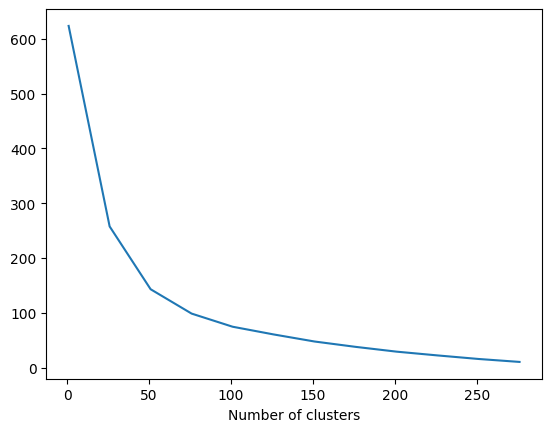

In [48]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [49]:
n_clusters = 50

kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
).fit(X_lsa)

In [50]:
# create a new column `title_cluster` and assign it the kmeans cluster labels
# First we need to map the labels to df_unique_articles article ids and then apply those to df
article_cluster_map = dict(zip(df_unique_articles, kmeans.labels_)) # Map article_id to cluster label
df['title_cluster'] = df['title'].map(article_cluster_map) # apply map to create title clusters

In [51]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[ 0, 23],
       [ 1,  6],
       [ 2, 70],
       [ 3, 18],
       [ 4, 31],
       [ 5,  9],
       [ 6, 26],
       [ 7, 37],
       [ 8, 16],
       [ 9, 14],
       [10, 37],
       [11, 20],
       [12, 13],
       [13, 20],
       [14, 14],
       [15, 28],
       [16, 23],
       [17,  6],
       [18, 19],
       [19,  9],
       [20, 10],
       [21,  8],
       [22,  7],
       [23,  7],
       [24, 22],
       [25, 10],
       [26, 12],
       [27, 22],
       [28, 16],
       [29, 13],
       [30,  8],
       [31,  8],
       [32, 13],
       [33,  7],
       [34,  7],
       [35,  7],
       [36, 12],
       [37,  4],
       [38,  3],
       [39,  6],
       [40, 10],
       [41,  8],
       [42,  8],
       [43,  5],
       [44,  8],
       [45,  8],
       [46,  7],
       [47,  7],
       [48,  4],
       [49,  8]])

In [57]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    articles_in_cluster = df[df["title_cluster"] == title_cluster]
    articles_in_cluster = articles_in_cluster[articles_in_cluster["article_id"] != article_id]
    articles_in_cluster = articles_in_cluster["article_id"].unique().tolist()
    return articles_in_cluster

In [58]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    
    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    similar_articles = get_similar_articles(article_id)
    n_ranked_similar_articles = get_ranked_article_unique_counts(similar_articles)[:n]
    n_ranked_similar_articles = [list[0] for list in n_ranked_similar_articles]
    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names
        

In [59]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1025, 101, 975, 766, 508, 547, 132, 878, 92, 693]
['better together: spss and data science experience', 'data science in the cloud', 'collecting data science cheat sheets', 'making data science a team sport', 'how to choose a project to practice data science', 'data tidying in data science experience', 'trust in data science', 'the data science process', '10 data science podcasts you need to be listening to right now', '9 mistakes to avoid when starting your career in data science']


In [60]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

The content-based recommendation system relies on natural language processing (NLP), specifically the TF-IDF technique, to extract meaningful information from the article titles. Using a vocabulary of 125 terms, the model groups articles into 50 clusters based on textual similarity. When a user requests recommendations for a specific article, the system identifies its cluster and then ranks and recommends other articles within the same cluster, assuming they share similar content.

The recommendation quality could be improved by incorporating additional textual information beyond the article title. For example, using the full article text, summaries, descriptions, or assigned keywords would provide richer context for clustering and similarity comparisons. Including these additional features would likely lead to more accurate and relevant recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [61]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

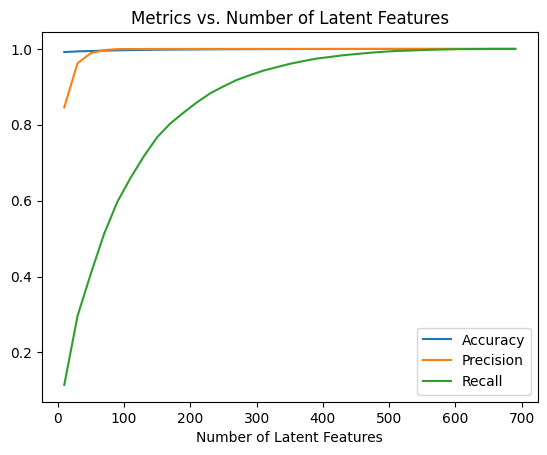

In [63]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

Choosing the optimal number of latent features is difficult because improving the model’s ability to reconstruct the user–item matrix (i.e., predicting 1s and 0s) does not necessarily guarantee better recommendations. A larger number of latent features typically increases recall, but it can also lead to overfitting and higher computational costs.

Based on the diagram, I would select 100 latent features. At this point, recall reaches approximately 0.7, and increasing the number of latent factors beyond this does not appear to yield meaningful improvements in either accuracy or precision. Therefore, 100 offers a good balance between performance and model complexity.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [64]:
def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    INPUT:
    article_id - (int) an article id
    vt - (numpy array) vt matrix from SVD
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids similar using SVD factorization
    """
    # Find the index of the article_id
    article_idx = user_item.columns.get_loc(article_id)
    # Find the cosine similarity of all articles
    # Hint: vt should be transposed before passing to cosine_similarity to get a 714 x 714 matrix
    cos_sim = cosine_similarity(vt.T)
    # Get similarities only for the cos_sim of the article_idx
    similar_indices = cos_sim[article_idx].argsort()[::-1]  # Sort in descending order
    # Sort and return the articles, don't include the own article
    most_similar_items = []
    for i in similar_indices:
        if user_item.columns[i] != article_id:
            most_similar_items.append(user_item.columns[i])
    if include_similarity:
        return [[item, cos_sim[article_idx][item]] for item in most_similar_items]
    return most_similar_items

In [65]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [66]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [67]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[np.int64(1199),
 np.int64(1068),
 np.int64(486),
 np.int64(1202),
 np.int64(176),
 np.int64(1120),
 np.int64(244),
 np.int64(793),
 np.int64(58),
 np.int64(132)]

In [68]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [69]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

Each recommendation approach used in the project operates differently and comes with its own strengths and limitations. Rank-based recommendation systems rely solely on overall article popularity. Because they do not require any user history, they work well for new users and naturally handle the cold start problem. In this project, such a system simply returns the most popular articles, which makes it simple and effective, though not personalized.

User–user collaborative filtering, on the other hand, makes recommendations by identifying users with similar interaction patterns. This method depends on user activity and therefore cannot handle cold start situations. However, for users with a moderate or large interaction history, it can provide highly personalized recommendations that reflect the preferences of similar users.

Content-based recommendation systems offer another alternative by relying on item characteristics rather than user behavior. They compare articles based on their content, allowing recommendations to be generated even when no user history is available. In this project, textual similarity between articles enables the system to suggest related items. While this approach works for both new and experienced users, it can be limited because it focuses only on items similar to what the user has already consumed.

Matrix factorization introduces yet another strategy by extracting latent factors that capture hidden patterns in user–item interactions. It can perform well with sparse data and does not require a long user history, though the meaning of latent factors is often difficult to interpret. This reduced interpretability can make it challenging to understand why certain recommendations are generated.

To determine whether these recommendation methods improve how users discover articles, one could evaluate them using A/B testing, monitor engagement metrics such as click-through rate or conversion rate, or collect direct user feedback. It would also be important to examine potential biases and ensure the recommendations promote a balanced content exposure.

Different recommendation techniques are best suited for different types of users. Rank-based and content-based methods are ideal for completely new users, since they do not require prior interactions. Content-based and matrix factorization approaches work well for users with limited history, while collaborative filtering and matrix factorization are especially powerful for users with extensive interaction data. In practice, combining several approaches into a hybrid system would yield the most robust and flexible recommendation strategy across all user scenarios.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [71]:
# from subprocess import call
# call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])
from subprocess import call

call([
    'python',
    '-m', 'jupyter',
    'nbconvert',
    '--to', 'html',
    'Recommendations_with_IBM.ipynb'
])


[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 552311 bytes to Recommendations_with_IBM.html


0